In [1]:
import warnings
warnings.filterwarnings('ignore')

### Allocating Dynamic GPU Memory


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

### Importing Libraries and Packages

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import concatenate
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_absolute_error
import csv
from matplotlib import pyplot
from keras.layers import CuDNNLSTM,merge, ConvLSTM2D, Lambda, Conv2DTranspose, Concatenate, Flatten, Conv2D, BatchNormalization, UpSampling2D, MaxPooling2D, MaxPooling3D, UpSampling3D
from keras import losses
from keras.layers import Input, Reshape
from keras.models import Model
import matplotlib.pyplot as plt
import keras
import pickle
from keras.layers import Bidirectional
import os
import sys
import time
from scipy.spatial import distance
from sklearn.metrics import hamming_loss
import keras.backend as K
import json

### Data path

In [4]:
#loading data
train_image_path = 'train/img'
train_mask_path = 'train/mask'

val_image_path = 'val/img'
val_mask_path = 'val/mask'

test_image_path = 'test/img'
test_mask_path = 'test/mask'

### Fetching data


In [5]:
def get_data(image_path, mask_path):
    train_images = sorted(os.listdir(image_path))
    mask_images = sorted(os.listdir(mask_path))
    i = 0
    x_nump = []
    y_nump = []
    
    for img in train_images:
        i = i + 1
        per = i / len(train_images) * 100

        x = Image.open(image_path + "/" + img)
        x = x.resize((480,320))
        x = x.convert('L')

        x = np.array(x)
        x = np.expand_dims(x, -1)
        x_nump.append(x)
    
    for img in mask_images:
        i = i + 1
        per = i / len(train_images) * 100
        
        y = Image.open(mask_path + "/" + img)
        y = y.resize((480,320))
        y = y.convert('L')
        y = np.array(y)
        y = np.expand_dims(y, -1)
        
        y_nump.append(y)
        
        
    x_nump = np.array(x_nump)
    y_nump = np.array(y_nump)
    y_nump[y_nump == 0] = 0
    y_nump[y_nump != 0] = 1

    return x_nump, y_nump

In [7]:
train_x , train_y = get_data(train_image_path, train_mask_path)
test_x , test_y = get_data(test_image_path, test_mask_path)

In [8]:
print(test_x.shape, test_y.shape)

(59, 320, 480, 1) (59, 320, 480, 1)


###  Normalizing data

In [13]:
mean = np.mean(train_x)
std = np.std(train_x)
del train_x, train_y
test_x = (test_x - mean) / std

### Concatenating images


In [17]:
#row by row sequence
def stretch_data(x_train, y_train):
    x_sequence = list()
    y_sequence = list()
    for img in x_train:
        for row in img:
            x_sequence.append(row)
            
    for img in y_train:
        for row in img:
            y_sequence.append(row)
        
    return np.array(x_sequence), np.array(y_sequence)

In [18]:
test_x_train_sequence, test_y_train_sequence = stretch_data(test_x,test_y)
del test_x,test_y

In [19]:
print(test_x_train_sequence.shape , test_y_train_sequence.shape)

(18880, 480, 1) (18880, 480, 1)


### Converting data into sequence

In [20]:
def get_sequence(x_train, y_train, time_step, window):
    amount_of_features = x_train.shape[1]
    sequence_length = time_step
    x_result = []
    y_result = []
    
    x_seq_res = []
    y_seq_res = []
    #Dividing the complete image sequence into blocks of shape window x features
    #Image 
    for index in range(0,len(x_train), window):
        x_result.append(x_train[index: index + window])
    #Mask
    for index in range(0,len(y_train), window):
        y_result.append(y_train[index: index + window])
        
    x_result = np.array(x_result)
    y_result = np.array(y_result)   
    print(x_result.shape)
    print(y_result.shape)
    
    #Making the sequence of shape time_step x window x features
    #Image 
    for index in range(len(x_result) - sequence_length):
        x_seq_res.append(x_result[index: index + sequence_length])
    #Mask
    for index in range(len(y_result) - sequence_length):
        y_seq_res.append(y_result[index + sequence_length - 1])

    x_seq_res = np.array(x_seq_res)
    y_seq_res = np.array(y_seq_res)
    print(x_seq_res.shape, y_seq_res.shape)
    
    return [x_seq_res, y_seq_res]

In [21]:
test_x_train, test_y_train = get_sequence(test_x_train_sequence, test_y_train_sequence, 8, 1)
del test_x_train_sequence, test_y_train_sequence

(18880, 1, 480, 1)
(18880, 1, 480, 1)
(18872, 8, 1, 480, 1) (18872, 1, 480, 1)


### Defining matrices and loss function

In [24]:
def mean_iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true)+K.sum(y_pred)-intersection
    iou = ((intersection) / (union + K.epsilon()))
    return iou

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    # some implementations don't square y_pred
    denominator = tf.reduce_sum(y_true + tf.square(y_pred))

    return numerator / (denominator + tf.keras.backend.epsilon())

In [25]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = ((2. * intersection)/(union + K.epsilon()))
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [28]:
def binary_focal_loss_fixed(y_true, y_pred, smooth = 1.0):
    
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.zeros_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    
    intersection = K.sum(pt_1)
    false_negative = K.sum(pt_0) 
    
    union = K.sum(y_true) + K.sum(y_pred)
    dice = ((2. * intersection)/(union + K.epsilon()))
    
    return (1-dice)

In [29]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(y_true * y_pred)
    predicted_positives = K.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [30]:
def loss(y_true, y_pred):
    return 1 - f1_m(y_true, y_pred)

### Defining Architecture

In [31]:
def get_model(pretrained_weights = None,input_size = (8, 1, 480, 1)):
    inputs = Input(input_size)
    conv1 = (ConvLSTM2D(64, kernel_size=(1,9), activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True))(inputs)
    bnorm1 = BatchNormalization()(conv1)
    drop1 = Dropout(0.2)(bnorm1)
    conv5 = ConvLSTM2D(1, kernel_size=(1,9), activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal', return_sequences=False)(drop1)
        
    #Model                     
    model = Model(input = inputs, output = conv5)
    model.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = binary_focal_loss_fixed , metrics = ['accuracy', dice_coef, mean_iou])
    
    if(pretrained_weights):
        print('loading_weights')
        model.load_weights(pretrained_weights)
    
    if(pretrained_weights):
        print('loading_weights')
        model.load_weights(pretrained_weights)

    return model

In [32]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 1, 480, 1)      0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 8, 1, 480, 64)     150016    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 1, 480, 64)     256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 1, 480, 64)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 480, 1)         2344      
Total params: 152,616
Trainable params: 152,488
Non-trainable params: 128
_________________________________________________________________


### Loading best saved weights

In [33]:
model = get_model('augmented_50_50_random_split_Crackforest_grayscale_input_2_layer_tanh_softmax_loss_f1_epochs_100_bs_320_lr_1e_4_input_8_1_480.hdf5')

loading_weights


In [35]:
model.metrics_names

['loss', 'acc', 'dice_coef', 'mean_iou', 'f1_m']

### Evaluating Model


In [33]:
score = model.evaluate(test_x_train, test_y_train, batch_size=320)
print(model.metrics_names, score)

18872/18872 [==============================] - 20s 1ms/step
['loss', 'acc', 'dice_coef', 'mean_iou', 'f1_m'] [0.4527508154568302, 0.9849004166365781, 0.5472491502275453, 0.3922544616902655, 0.5472490902975891]


In [36]:
time1 = time.time()
y_pred = model.predict(test_x_train)
time2 = time.time()
print('{:s} function took {:.3f} ms', (time2-time1))

{:s} function took {:.3f} ms 23.245701551437378


In [37]:
print(np.unique(y_pred, return_counts=True))

(array([0.0000000e+00, 1.0877848e-05, 1.5664101e-04, ..., 9.9999559e-01,
       9.9999821e-01, 1.0000000e+00], dtype=float32), array([8881420,       1,       1, ...,       1,       1,  149002]))


### Visualizing Results

(18872, 1, 480, 1)
(18880, 1, 480, 1)
1


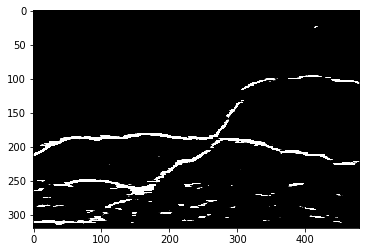

2


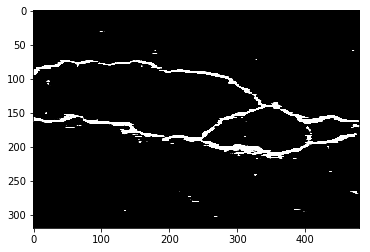

3


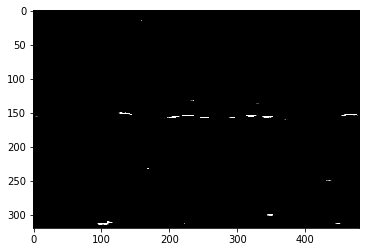

4


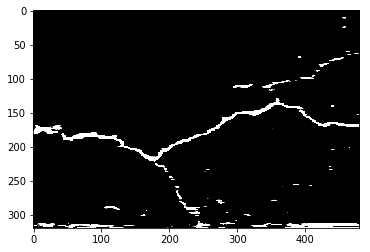

5


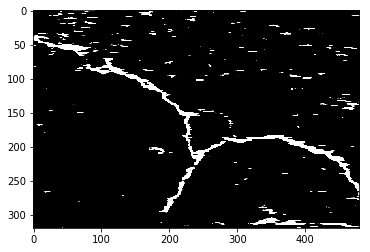

6


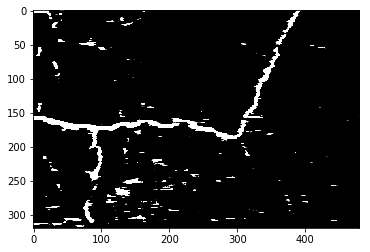

7


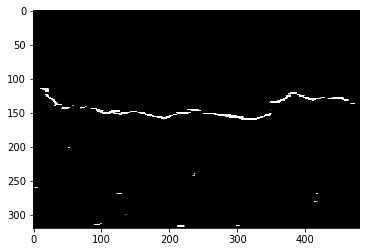

8


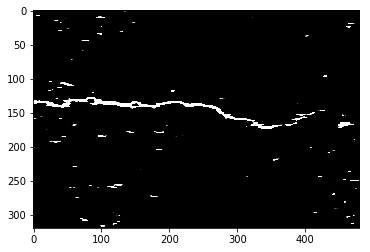

9


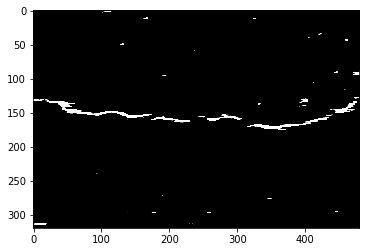

10


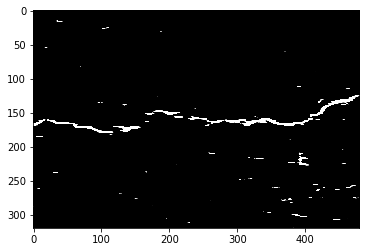

11


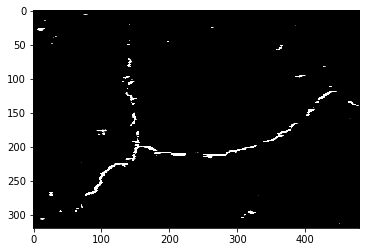

12


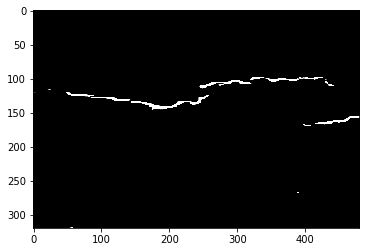

13


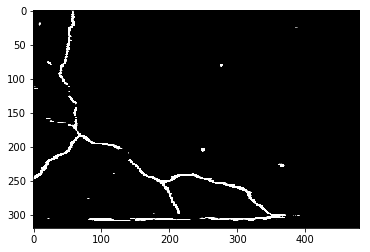

14


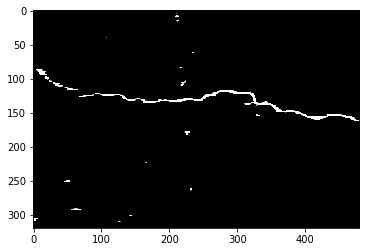

15


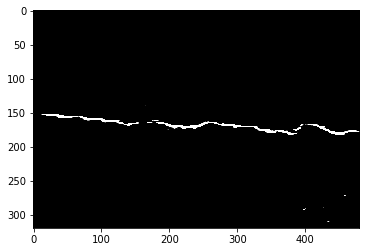

16


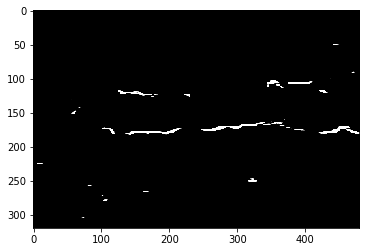

17


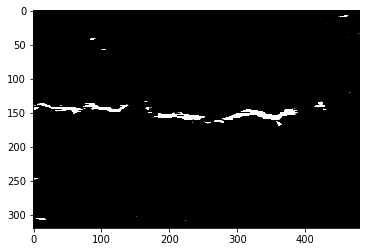

18


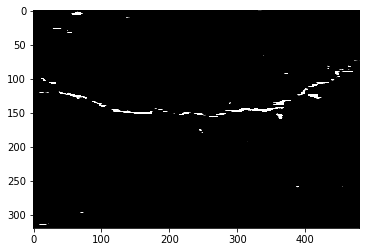

19


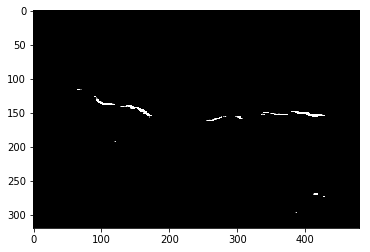

20


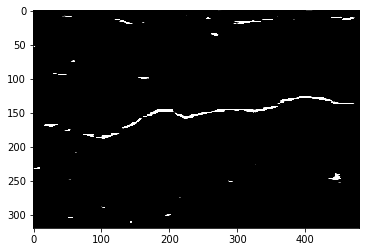

21


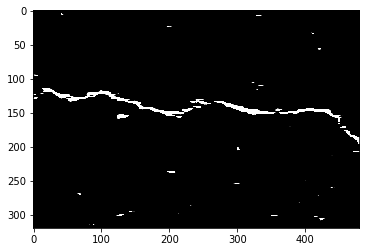

22


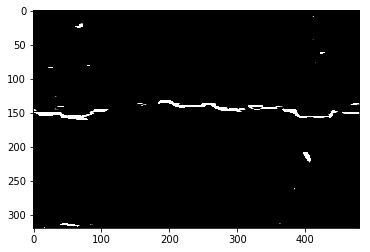

23


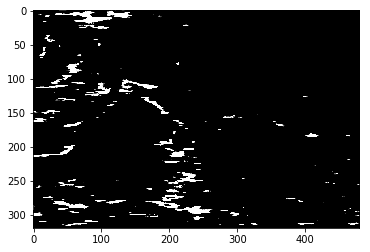

24


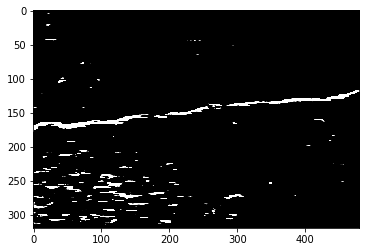

25


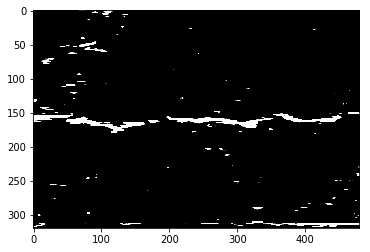

26


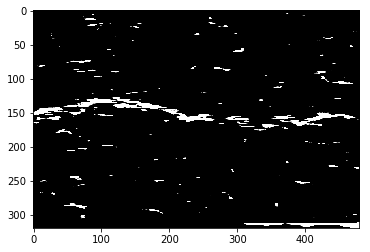

27


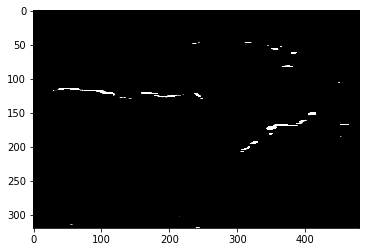

28


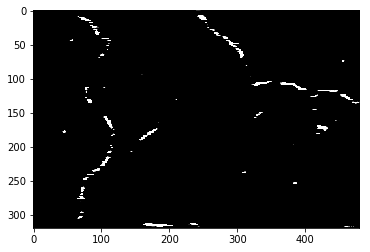

29


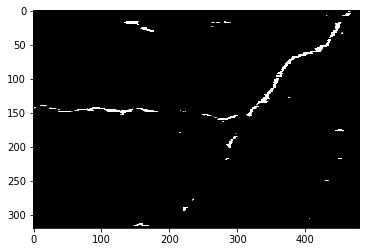

30


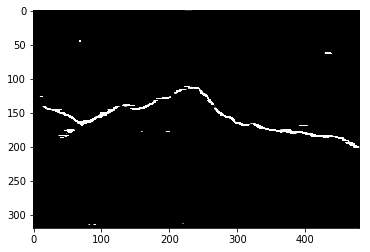

31


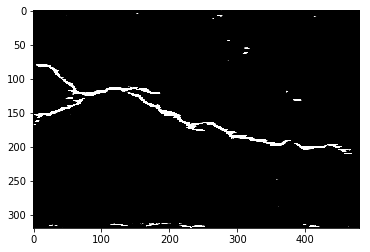

32


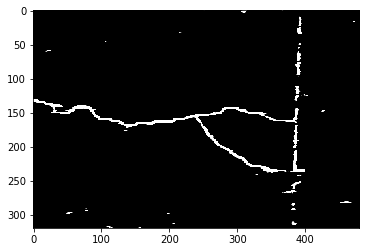

33


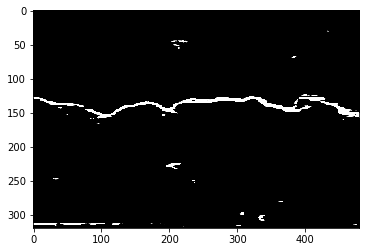

34


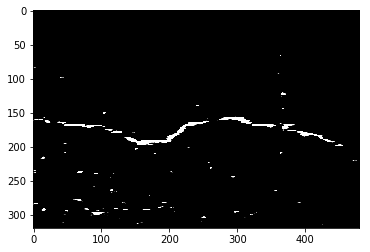

35


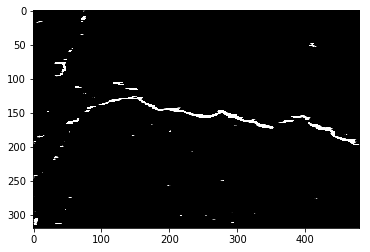

36


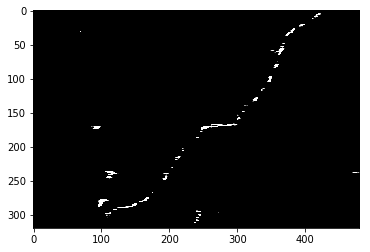

37


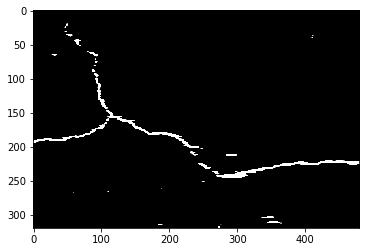

38


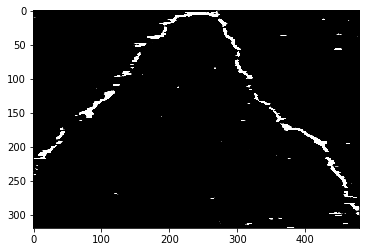

39


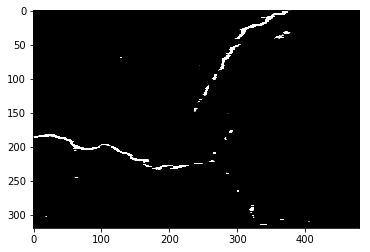

40


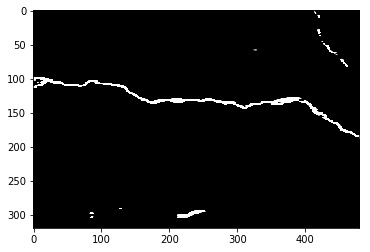

41


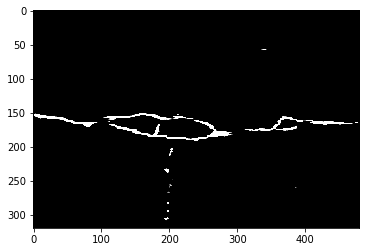

42


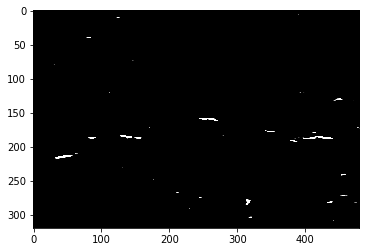

43


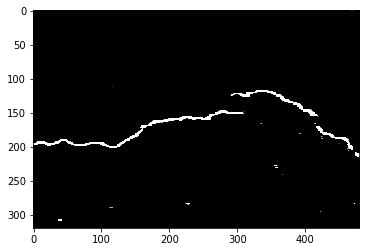

44


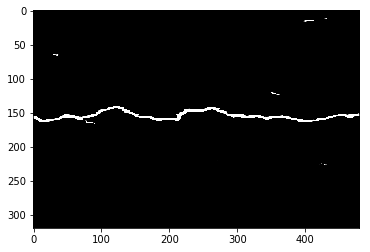

45


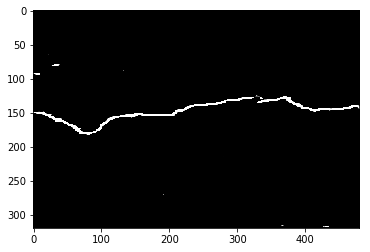

46


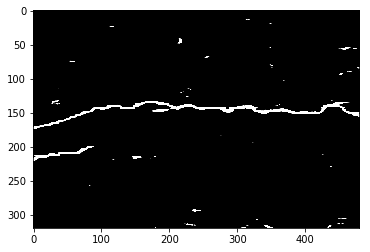

47


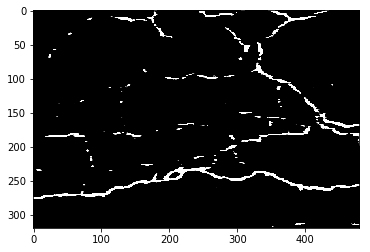

48


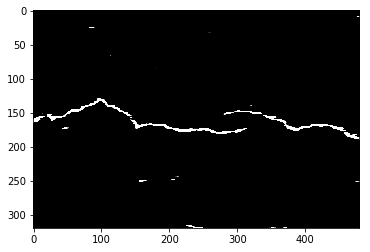

49


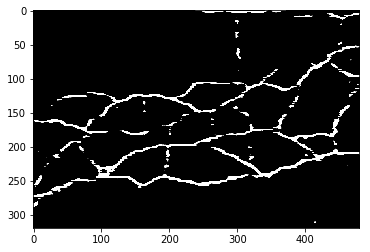

50


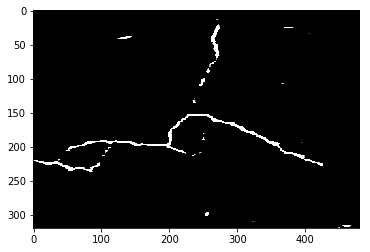

51


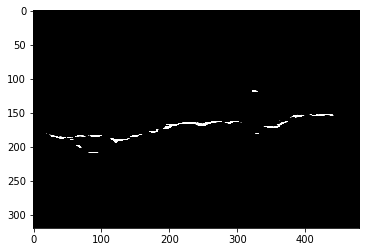

52


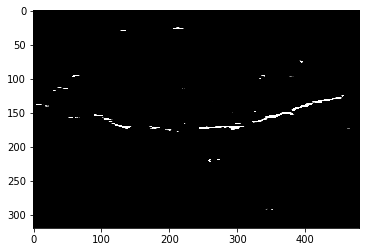

53


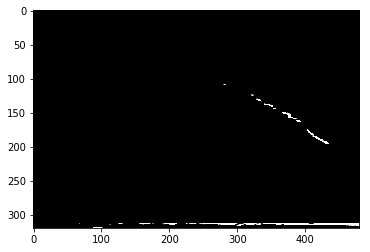

54


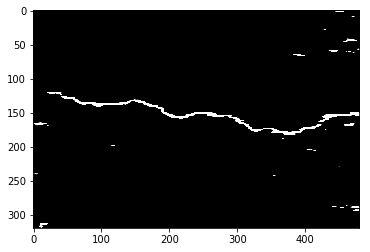

55


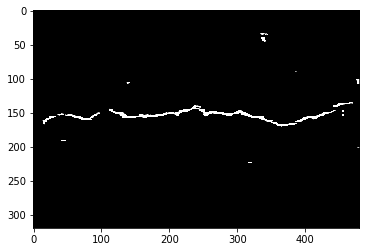

56


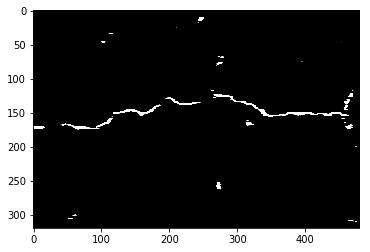

57


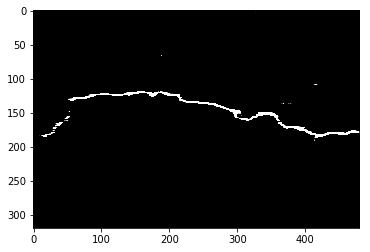

58


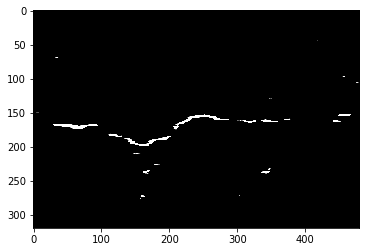

59


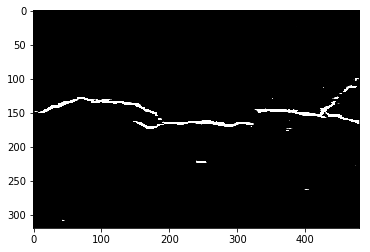

In [38]:
print(y_pred.shape)
temp = np.zeros((8, 1, 480, 1))
y_pred = np.append(y_pred, temp, axis = 0)
print(y_pred.shape)
temp_y = np.reshape(y_pred, (59, 320, 480))
i = 0
for sequence in range(len(temp_y)):
    i+=1
    print(i)
    plt.imshow(temp_y[sequence], cmap='gray')
    plt.pause(0.005)

(18872, 1, 480, 1)
(18880, 1, 480, 1)
1


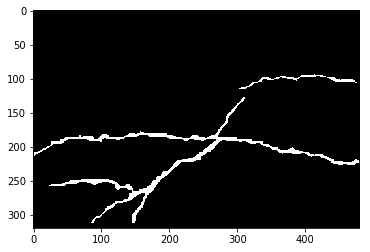

2


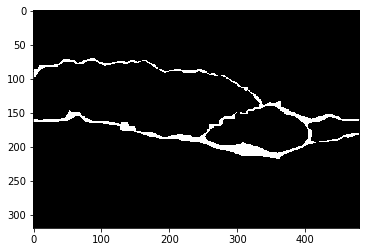

3


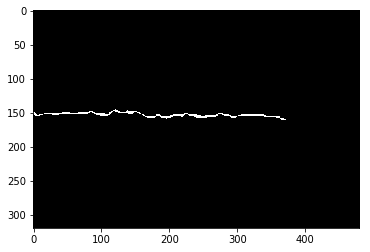

4


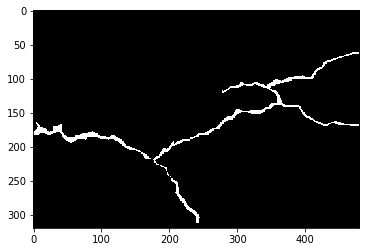

5


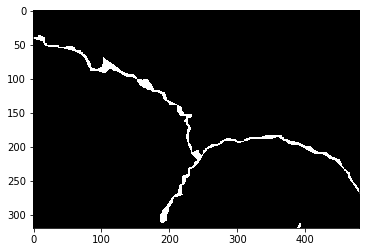

6


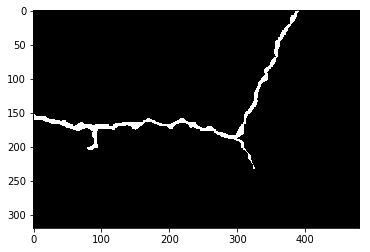

7


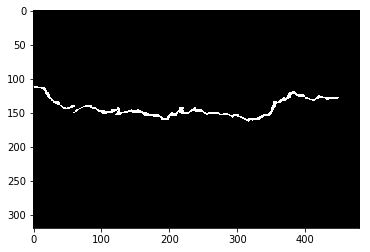

8


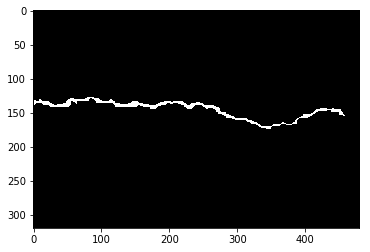

9


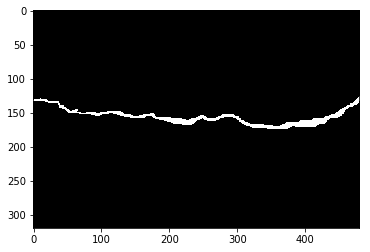

10


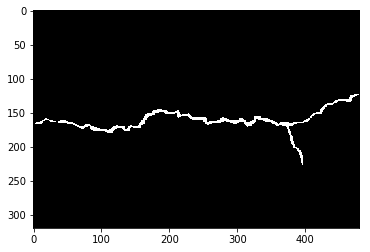

11


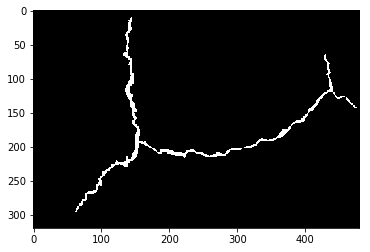

12


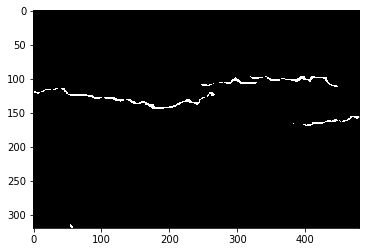

13


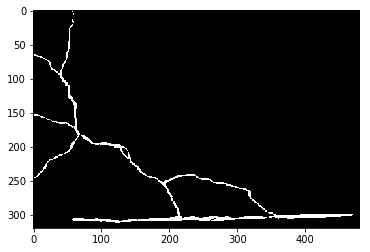

14


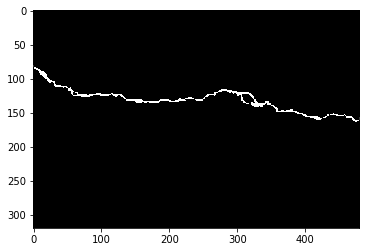

15


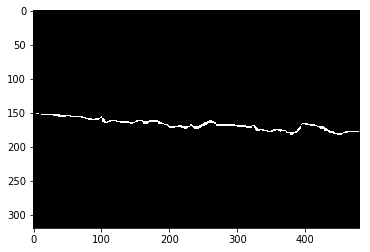

16


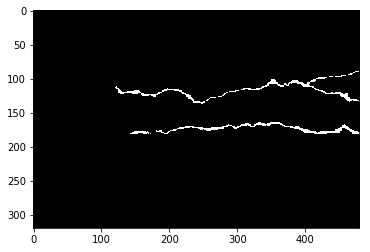

17


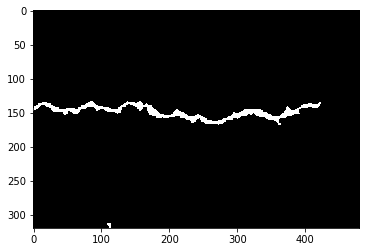

18


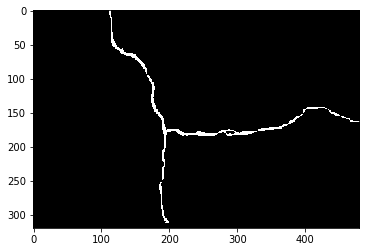

19


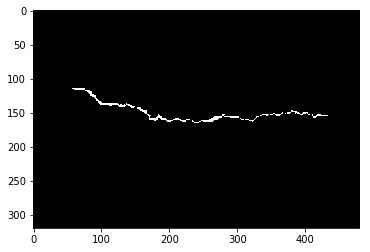

20


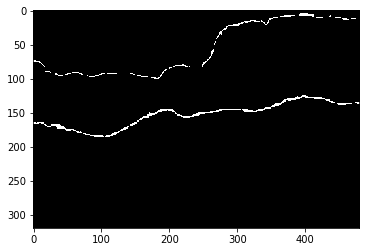

21


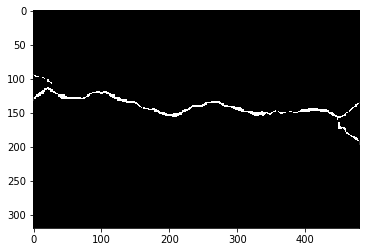

22


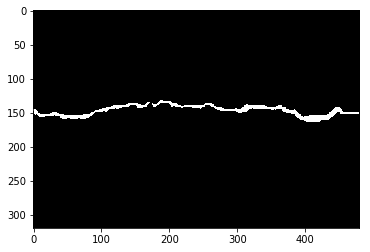

23


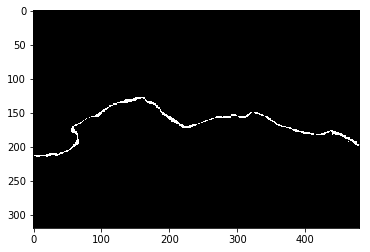

24


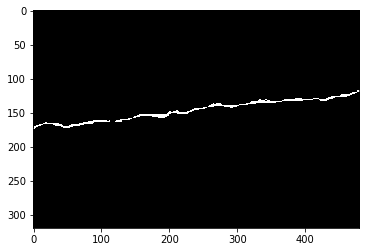

25


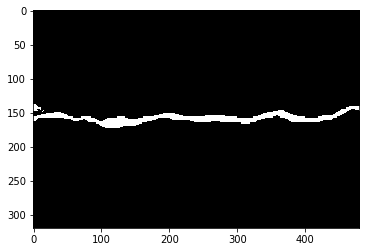

26


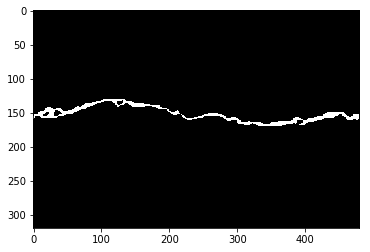

27


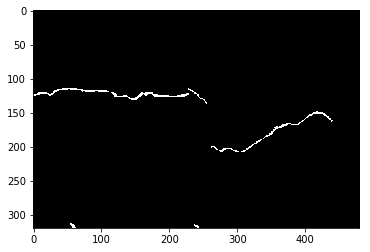

28


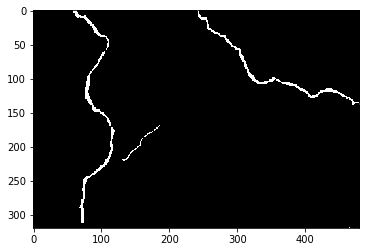

29


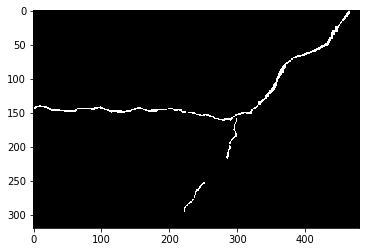

30


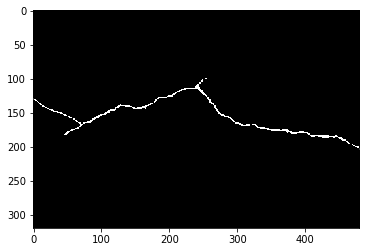

31


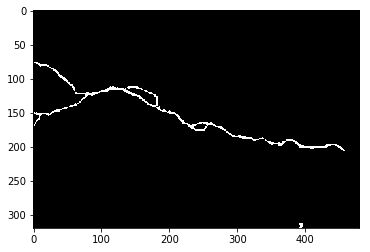

32


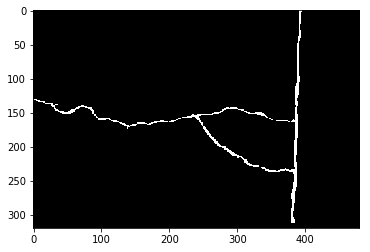

33


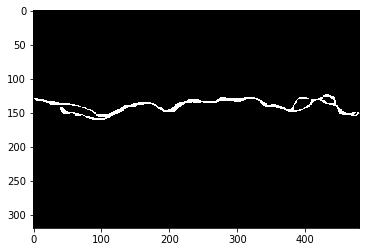

34


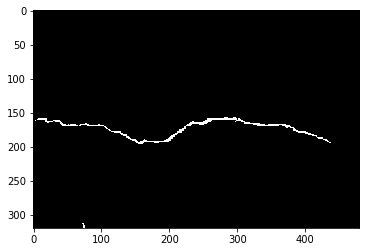

35


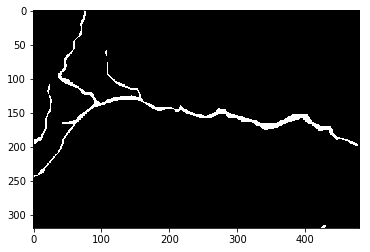

36


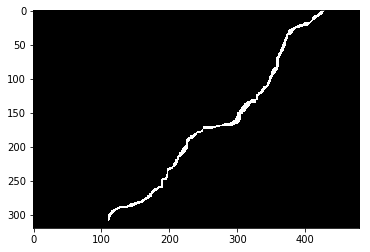

37


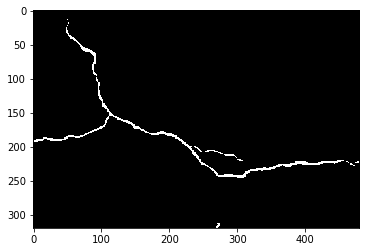

38


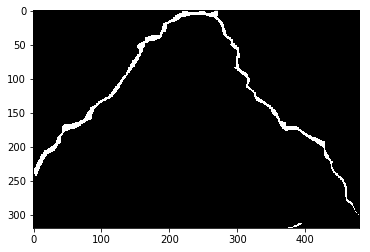

39


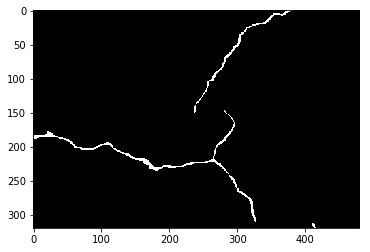

40


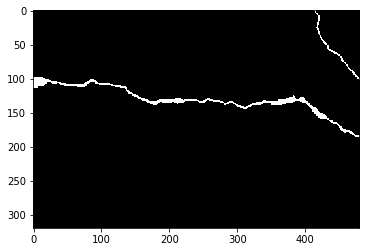

41


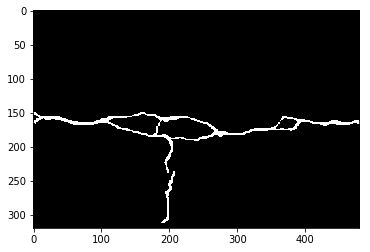

42


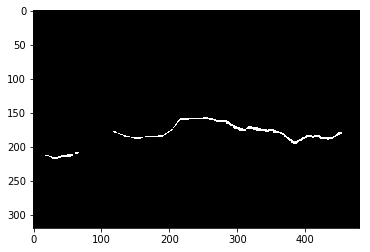

43


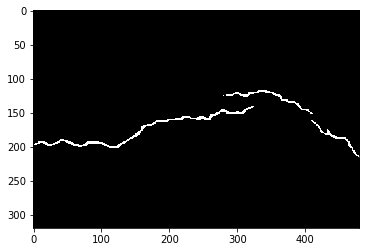

44


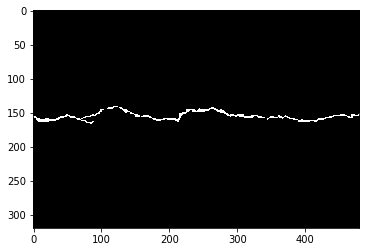

45


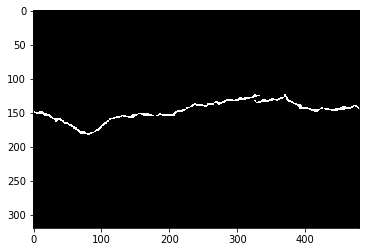

46


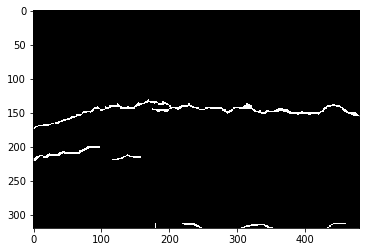

47


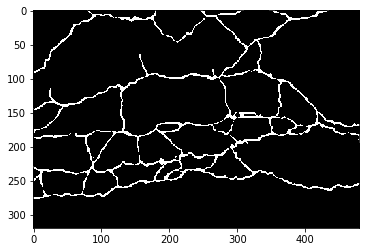

48


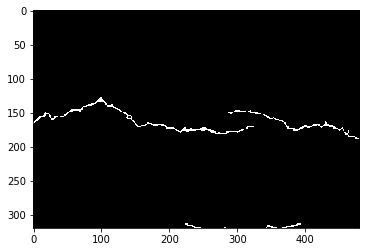

49


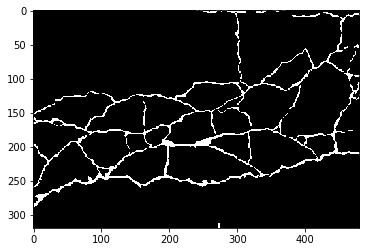

50


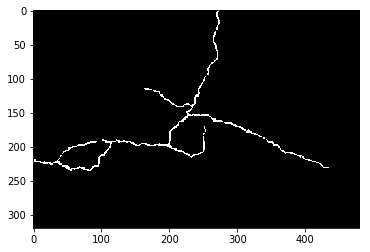

51


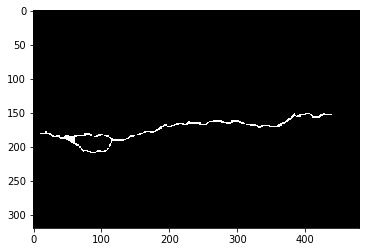

52


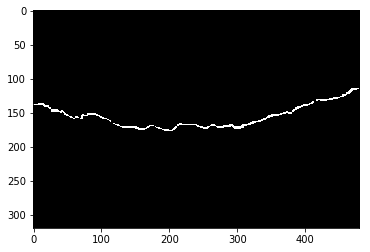

53


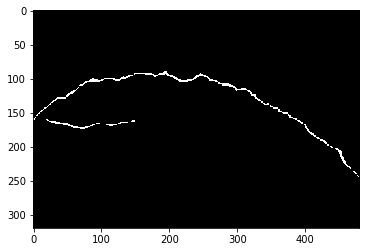

54


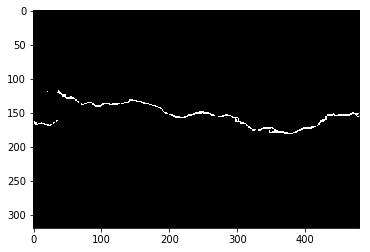

55


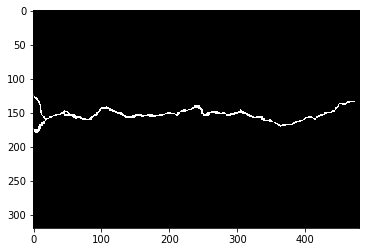

56


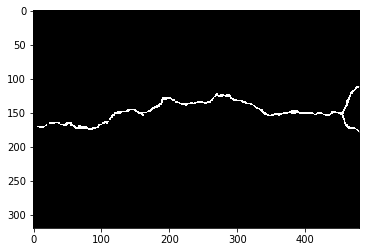

57


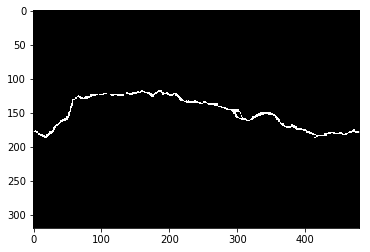

58


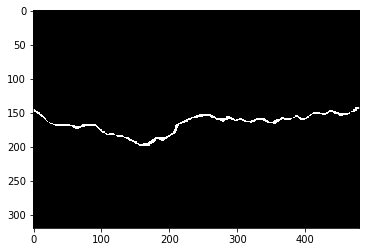

59


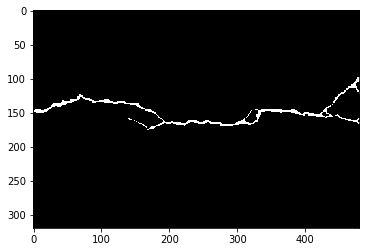

In [39]:
print(test_y_train.shape)
temp = np.zeros((8, 1, 480, 1))
test_y_train = np.append(test_y_train, temp, axis = 0)
print(test_y_train.shape)
temp_y = np.reshape(test_y_train, (59, 320, 480))
i = 0
for sequence in range(len(temp_y)):
    i+=1
    print(i)
    plt.imshow(temp_y[sequence], cmap='gray')
    plt.pause(0.005)

In [40]:
def concat_img(data):
    frames = list()
    row_len = 320
    for rows in range(0,len(data), row_len):
        frames.append(data[rows:rows+row_len])
    frames = np.array(frames)
    return frames

In [41]:
frames_img = concat_img(y_pred)
print(frames_img.shape)

(59, 320, 1, 480, 1)


In [42]:
y_frames_img = concat_img(test_y_train)
print(y_frames_img.shape)

(59, 320, 1, 480, 1)


In [43]:
frames_img = np.reshape(frames_img, (59,320,480))
y_frames_img = np.reshape(y_frames_img, (59,320,480))

### Dice-coeff, MIOU, Recall, Precision, F-1

In [49]:
def dice_score(y_true, y_pred, smooth=1):   
    intersection = np.sum(np.multiply(y_true ,y_pred))
    union = np.sum(y_true) + np.sum(y_pred)
    iou = (2. * intersection) / (union + K.epsilon())
    return iou

In [50]:
dice_scores = list()
for frames in range(len(frames_img)):
    dice_scores.append(dice_score(y_frames_img[frames],frames_img[frames]))
dice_scores = np.array(dice_scores)
print(np.mean(dice_scores))

0.5473164445414529


In [51]:
def iou(y_true, y_pred, smooth=1):   
    intersection = np.sum(np.multiply(y_true ,y_pred))
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = (intersection) / (union + K.epsilon())
    return iou

In [52]:
iou_scores = list()
for frames in range(len(frames_img)):
    iou_scores.append(iou(y_frames_img[frames],frames_img[frames]))
iou_scores = np.array(iou_scores)
print(np.mean(iou_scores))

0.3923194657424198


In [53]:
def recall_m(y_true, y_pred):
    true_positives = np.sum(np.multiply(y_true ,y_pred))
    possible_positives = np.sum(y_true)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = np.sum(np.multiply(y_true ,y_pred))
    predicted_positives = np.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall + K.epsilon()))

In [54]:
recall_scores = list()
for frames in range(len(frames_img)):
    recall_scores.append(recall_m(y_frames_img[frames],frames_img[frames]))
recall_scores = np.array(recall_scores)
print(np.mean(recall_scores))

0.5858631270215015


In [55]:
prec_scores = list()
for frames in range(len(frames_img)):
    prec_scores.append(precision_m(y_frames_img[frames],frames_img[frames]))
prec_scores = np.array(prec_scores)
print(np.mean(prec_scores))

0.5478618399692304


In [56]:
f1_scores = list()
for frames in range(len(frames_img)):
    f1_scores.append(f1_m(y_frames_img[frames],frames_img[frames]))
f1_scores = np.array(f1_scores)
print(np.mean(f1_scores))

0.5473163967423615
